## Overview

This notebook performs sentiment analysis on twitter dataset obtained from Kaggle

Link to dataset: https://www.kaggle.com/c/twitter-sentiment-analysis2/data

- **Section 1: Exploring the training dataset**
- Section 2: Test data
- Section 3: Pre-Processing data for Sentiment Analysis
- Section 4: Training and Evaluation
- Section 5: Metrics, Measurements and Conclusion



## Section1: Exploring the training dataset

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk

In [2]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

#Explore the training dataset
#Note: For some reason, if you dont specify the encoding as latin-1, the interpreter will throw an UTF-8 encoding error
data = pd.read_csv(train_file, error_bad_lines=False, encoding='latin-1')
data.columns = ['id', 'sentiment', 'text']
data.head(2)

,id,sentiment,text
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...


In [3]:
#Id information is not useful. So let's remove it
#axis=1 indicates columns
data = data.drop(labels=['id'], axis=1)
data.head(10)

,sentiment,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| ...
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)


### Observations:
1. Data has a mix of alphabets, numbers and symbols
2. Mix of words with uppercase and lowercase letters
3. We need to normalize the words to their base word. Leaving capitalizaed words in the middle of the tweet can be
   experimented with as they may hold different feature space like name of the person, country, etc.. 
4. No particular order of sentiment and tweets. If data is not randomly distributed then it can introduce bias to a learning model
5. Need to split and shuffle the data to reduce variance (makes sure the model can generalize better on the data) 
   and does not lead to overfitting 
6. Need to get an idea of the distribution of data

In [5]:
# calculate the number of positive and negative tweets
positives = data['sentiment'][data.sentiment == 1]
negatives = data['sentiment'][data.sentiment == 0]

print('Number of postive tweets {}' .format(len(positives)))
print('Number of negative tweets {}' .format(len(negatives)))
print('Total Length of the data is: {}' .format(data.shape[0]))

Number of postive tweets 56457
Number of negative tweets 43532
Total Length of the data is: 99989


### More observations
7. From the result, looks like an even distribution of positive and negative sentiments
8. Are there any duplicates in the data? Get the unique counts to identify this
9. How many average number of words are there in a tweet? Do a word count
10. What are the most common words present in the dataset?

In [6]:
data.groupby('sentiment').describe()

text                                                            \
           count unique                                                top   
sentiment                                                                    
0          43532  43532  @Aneesaah__x i feel like shit bcz of that sada...   
1          56457  56457  @ashaj Those lucky geniuses! Hope you're havin...   

                
          freq  
sentiment       
0            1  
1            1

Seems like there are no duplicates

In [10]:
# Function to calculate the number of words in a sentence.
# Using the delimiter to be a space
def word_count(tweet):
    return len(tweet.split())

data['word_count'] = data['text'].apply(word_count)
data.head(5)

,sentiment,text,word_count
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,25
4,0,i think mi bf is cheating on me!!! ...,9


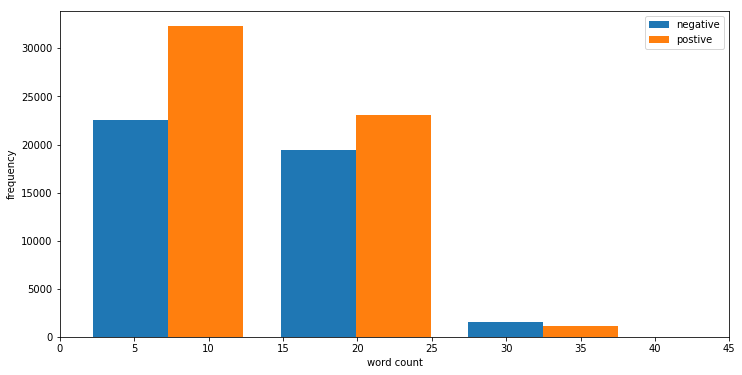

In [26]:
# Plot a histogram of the word counts

x = data['word_count'][data.sentiment == 0]
y = data['word_count'][data.sentiment == 1]
plt.figure(figsize=(12,6))
plt.xlabel('word count')
plt.ylabel('frequency')
graph = plt.hist([x,y], label=['negative', 'postive'])
plt.xlim(0,45)
plt.legend(loc='upper right')

### More observations

- From the histogram, it seems like most data seems to be less than 25 words. This is mostly because the tweet is less than 280 characters and so this data is good representative for twitter data
- Majority of them in the range of 5 to 10. 
- As the word count increases, the tweets tend to be negative
- There are more postive sentences/tweets which are 10 words an less


In [28]:
# Collect all the words in the training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

Counter(all_words).most_common(15)

[('i', 48880),
 ('the', 29629),
 ('to', 29177),
 ('you', 23456),
 ('a', 21908),
 ('and', 15826),
 ('it', 14154),
 ('my', 13598),
 ('for', 12378),
 ('is', 11618),
 ('in', 11497),
 ('of', 10519),
 ('that', 10051),
 ('have', 9794),
 ('on', 9228)]

- This shows the top 15 common words in the training dataset
- From the list, the stop words like **the**, **to** etc.. are very highly used. They are generally used in both positive and negative expressions and hence do not add any information that can be incorporated into the model. So these words can be removed from the data set

###  Frequency Distribution
Frequency distribution = frequency of each vocabulary item in the text

It is a distribution because it tells us how the total number of word tokens in the text are distributed across the vocabulary items. 

Reference: https://www.nltk.org/book/ch01.html

<FreqDist with 165473 samples and 1330178 outcomes>


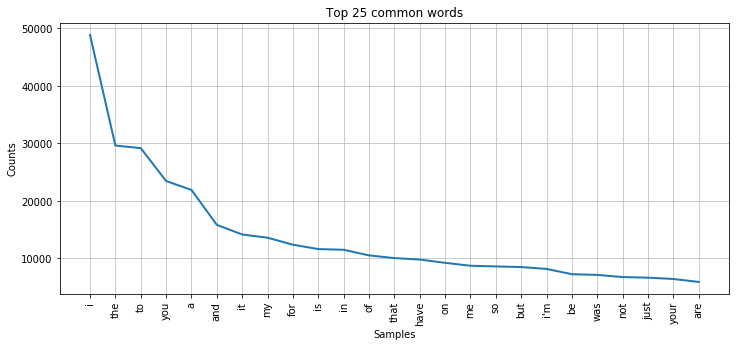

In [36]:
# plot word frequency distribution of top common words
plt.figure(figsize=(12,5))
plt.title("Top 25 common words")
fd = nltk.FreqDist(all_words)
print(fd)
fd.most_common(25)
fd.plot(25, cumulative=False)

### Log-Log Plot

Both dimensions are in logarithmic scale.

Reasons to construct a log log plot:

1. To respond to skewness towards large values; i.e., cases in which one or a few points are much larger than the bulk of the data.
2. To show percent change or multiplicative factors.

Text(0.5,1,"Log-Log Plot of words' frequency")

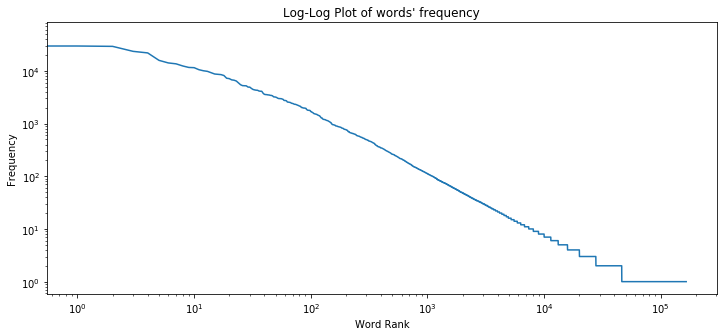

In [40]:
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts)
plt.xlabel("Word Rank")
plt.ylabel("Frequency")
plt.title("Log-Log Plot of words' frequency")

The log-log plot for the words frequency and word rank. It is for the entire training dataset. 

- Seems like the frequency drops as the rank decreases (Note: As far as word rank goes, higher the number lower the rank)
- Need to check if this still holds true after removing the stop words